# 第4章 [実践] 深層学習

このノートブックでは、第4章で説明した GoogLeNet による一般物体認識の再現を行います。

## 環境構築

このノートブックの内容をお手元のコンピュータ上で再現するには、[Caffe](http://caffe.berkeleyvision.org/installation.html) の実行環境を構築し、IPython のインストールも必要です。IPython は第2章用の環境構築によってインストールされるので、第2章のノートブックをご覧になってください。

### Caffe のインストール

まず、Caffe を GitHub からクローンします。Caffe のリポジトリ [BVLC/caffe](https://github.com/BVLC/caffe/) は本リポジトリにサブモジュールとして追加してあります。ですから、次のコマンドでクローンし、`caffe` ディレクトリに入ってください。

```
$ git submodule update --init caffe
$ cd caffe
```

次に、Caffe のインストールです。インストール方法は "[Installation](http://caffe.berkeleyvision.org/installation.html)" に記載されています。このページを参照して環境を構築してください。

本ノートブックは pycaffe を使用しています。Caffe の Installation ページではオプショナル扱いになっていますが、pycaffe のインストールも忘れずに行ってください。pycaffe のインストール手順をまとめると以下のとおりです。

```
$ for req in $(cat python/requirements.txt); do pip install $req; done
$ make pycaffe
```

## 準備

ノートブックの環境を準備します。

### matplotlib の設定

まずは matplotlib の設定です。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

以下の設定で `pyplot.imshow` で表示される画像のサイズを大きくします。

In [2]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### pycaffe のロード

次に pycaffe をロードします。

In [3]:
import os
import sys

caffe_root = os.path.expanduser("caffe")
sys.path.insert(0, caffe_root + '/python')
import caffe

### Caffe の設定

Caffe で 0 番目の GPU を使用するように設定します。Caffe を CPU モードでビルドした読者は、以下のコードを実行しないでください。

In [4]:
caffe.set_device(0)
caffe.set_mode_gpu()

## 必要なファイルのダウンロードとロード

モデルファイルが無い場合はダウンロードします

In [5]:
googlenet_dir = os.path.expanduser(caffe_root + '/models/bvlc_googlenet/')
if not os.path.isfile(googlenet_dir + 'bvlc_googlenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !caffe/scripts/download_model_binary.py caffe/models/bvlc_googlenet

...100%, 51 MB, 9564 KB/s, 5 seconds passed

ラベルファイルも同様に存在しない場合はダウンロードします

In [6]:
# ラベルを読み込む
imagenet_labels_filename = caffe_root + '/data/ilsvrc12/synset_words.txt'
if not os.path.isfile(imagenet_labels_filename):
    print("Downloading ImageNet labels...")
    !caffe/data/ilsvrc12/get_ilsvrc_aux.sh

Downloading...
--2015-10-14 16:44:53--  http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858008 (17M) [application/octet-stream]
Saving to: ‘caffe_ilsvrc12.tar.gz’

100%[======================================>] 17,858,008  5.76MB/s   in 3.0s   

2015-10-14 16:44:56 (5.76 MB/s) - ‘caffe_ilsvrc12.tar.gz’ saved [17858008/17858008]

Unzipping...
Done.


ダウンロードしたモデルとラベルをロードします。

In [7]:
# モデルファイルのロード
net = caffe.Net(googlenet_dir + 'deploy.prototxt',
                googlenet_dir + 'bvlc_googlenet.caffemodel',
                caffe.TEST)
# ラベルファイルのロード
imagenet_labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

## 入力画像の変換器の作成

In [8]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + '/python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2,1,0))

## 入力画像の読み込みと変換結果の可視化

In [9]:
image_file = 'momosan.jpg'
image = caffe.io.load_image(image_file)
net.blobs['data'].data[...] = transformer.preprocess('data', image)

(-0.5, 223.5, 223.5, -0.5)

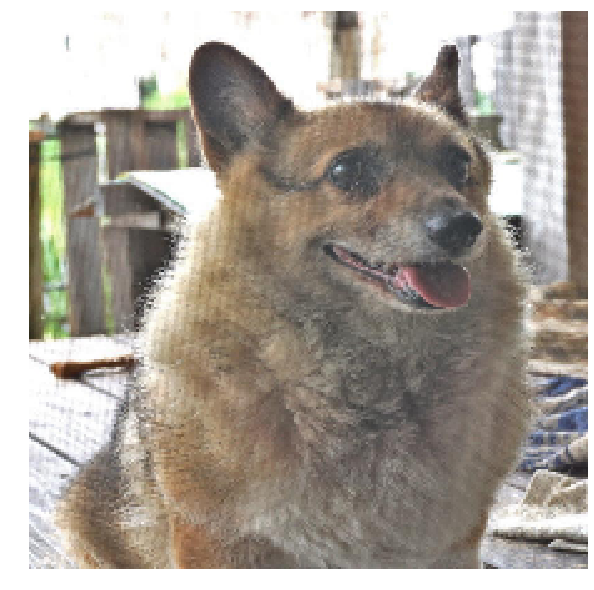

In [10]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))
plt.axis('off')

## 分類予測の算出と予測確率が高いラベルの取得

In [13]:
# ソフトマックス出力からトップ k 予測を取り出す
out = net.forward()
print("Predicted class is #{}.".format(out['prob'].argmax()))
prob = net.blobs['prob'].data[0].flatten()
top_k = prob.argsort()[-1:-10:-1]
for i, label in enumerate(imagenet_labels[top_k], start=1):
    print("{}: {}".format(i, label))

Predicted class is #225.
1: n02105162 malinois
2: n01877812 wallaby, brush kangaroo
3: n02106662 German shepherd, German shepherd dog, German police dog, alsatian
4: n02105412 kelpie
5: n02115641 dingo, warrigal, warragal, Canis dingo
6: n02091467 Norwegian elkhound, elkhound
7: n02114712 red wolf, maned wolf, Canis rufus, Canis niger
8: n02113186 Cardigan, Cardigan Welsh corgi
9: n02115913 dhole, Cuon alpinus


## GoogLeNet の隠れ層の可視化

### 各階層の出力の大きさ

In [14]:
# ネットワークの各層の形
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (10, 3, 224, 224)),
 ('conv1/7x7_s2', (10, 64, 112, 112)),
 ('pool1/3x3_s2', (10, 64, 56, 56)),
 ('pool1/norm1', (10, 64, 56, 56)),
 ('conv2/3x3_reduce', (10, 64, 56, 56)),
 ('conv2/3x3', (10, 192, 56, 56)),
 ('conv2/norm2', (10, 192, 56, 56)),
 ('pool2/3x3_s2', (10, 192, 28, 28)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_0', (10, 192, 28, 28)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_1', (10, 192, 28, 28)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_2', (10, 192, 28, 28)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_3', (10, 192, 28, 28)),
 ('inception_3a/1x1', (10, 64, 28, 28)),
 ('inception_3a/3x3_reduce', (10, 96, 28, 28)),
 ('inception_3a/3x3', (10, 128, 28, 28)),
 ('inception_3a/5x5_reduce', (10, 16, 28, 28)),
 ('inception_3a/5x5', (10, 32, 28, 28)),
 ('inception_3a/pool', (10, 192, 28, 28)),
 ('inception_3a/pool_proj', (10, 32, 28, 28)),
 ('inception_3a/output', (10, 256, 28, 28)),
 ('inception_3a/output_inception_3a/output_0_split_0', (10, 256, 28, 28)),
 ('inception_3a/output_inception_

### 各階層の結合パラメータの大きさ

In [15]:
# ネットワークの結合パラメタの形
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1/7x7_s2', (64, 3, 7, 7)),
 ('conv2/3x3_reduce', (64, 64, 1, 1)),
 ('conv2/3x3', (192, 64, 3, 3)),
 ('inception_3a/1x1', (64, 192, 1, 1)),
 ('inception_3a/3x3_reduce', (96, 192, 1, 1)),
 ('inception_3a/3x3', (128, 96, 3, 3)),
 ('inception_3a/5x5_reduce', (16, 192, 1, 1)),
 ('inception_3a/5x5', (32, 16, 5, 5)),
 ('inception_3a/pool_proj', (32, 192, 1, 1)),
 ('inception_3b/1x1', (128, 256, 1, 1)),
 ('inception_3b/3x3_reduce', (128, 256, 1, 1)),
 ('inception_3b/3x3', (192, 128, 3, 3)),
 ('inception_3b/5x5_reduce', (32, 256, 1, 1)),
 ('inception_3b/5x5', (96, 32, 5, 5)),
 ('inception_3b/pool_proj', (64, 256, 1, 1)),
 ('inception_4a/1x1', (192, 480, 1, 1)),
 ('inception_4a/3x3_reduce', (96, 480, 1, 1)),
 ('inception_4a/3x3', (208, 96, 3, 3)),
 ('inception_4a/5x5_reduce', (16, 480, 1, 1)),
 ('inception_4a/5x5', (48, 16, 5, 5)),
 ('inception_4a/pool_proj', (64, 480, 1, 1)),
 ('inception_4b/1x1', (160, 512, 1, 1)),
 ('inception_4b/3x3_reduce', (112, 512, 1, 1)),
 ('inception_4b/3x3', (2

### 可視化用の関数定義

以下の関数で、フィルタと隠れ層の可視化を行います。

In [16]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0, gamma=1):
    data -= data.min()
    data /= data.max()
    data = np.power(data, gamma)

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)
    plt.axis('off')

### C1層の可視化

C1 層のパラメータ (図8) は以下のようになっています。

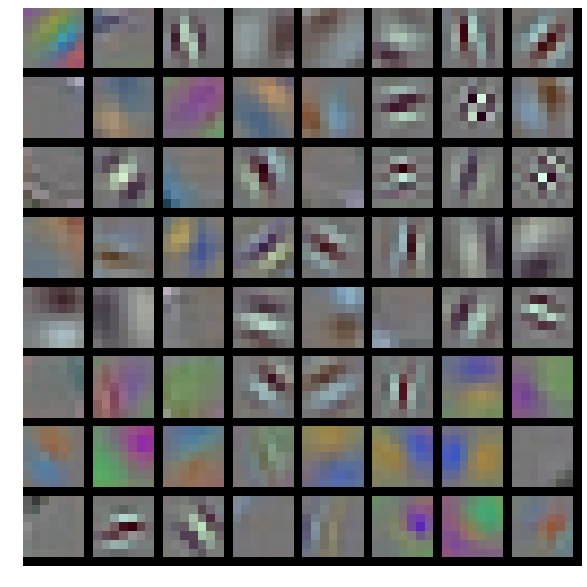

In [17]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1/7x7_s2'][0].data
vis_square(filters.transpose(0, 2, 3, 1), padsize=1)

C1 層の出力の一部をガンマ補正したもの (図9) は以下のとおりです。

(64, 112, 112)


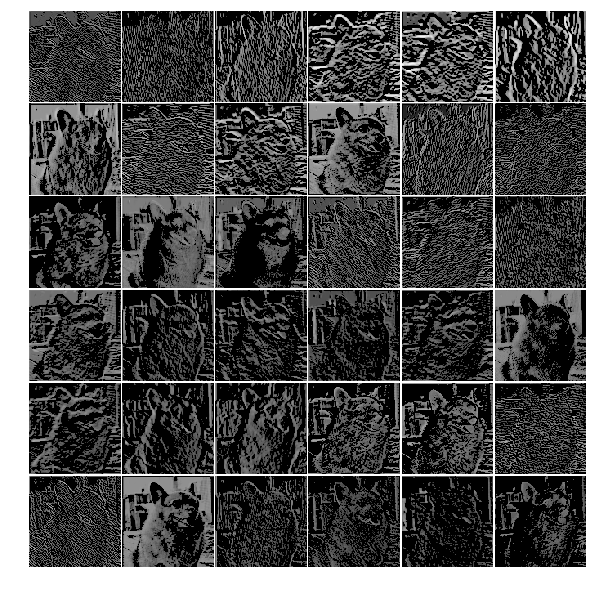

In [18]:
feat = net.blobs['conv1/7x7_s2'].data[0]
print(feat.shape)
vis_square(feat[28:64], padval=1, padsize=2, gamma=0.2)

### C2 層の可視化

次は、誌面には掲載していない C2 層のパラメータと出力です。

(192, 64, 3, 3)


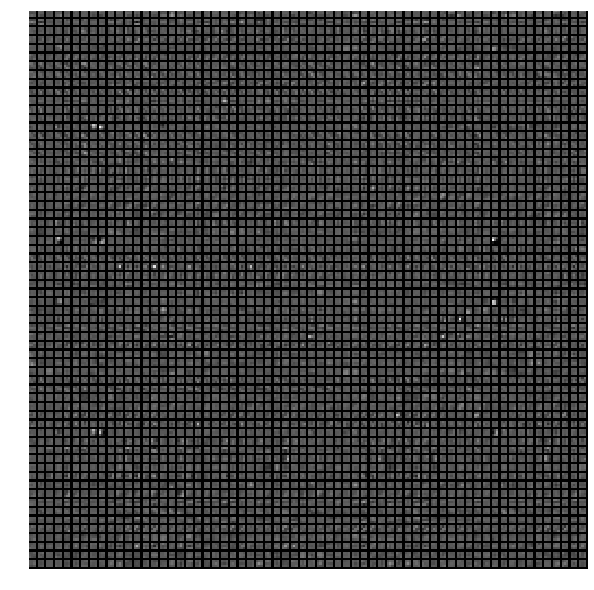

In [19]:
filters = net.params['conv2/3x3'][0].data
print(filters.shape)
vis_square(filters[:64].reshape(64**2, 3, 3), padval=0, padsize=1)

(192, 56, 56)


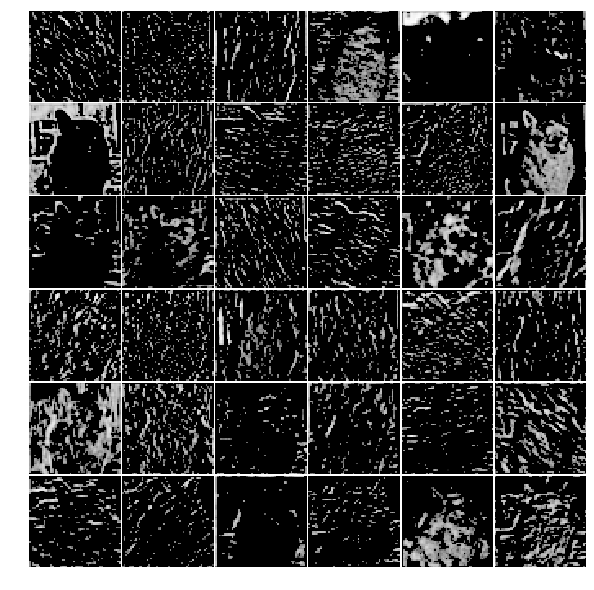

In [20]:
feat = net.blobs['conv2/3x3'].data[0]
print(feat.shape)
vis_square(feat[28:64], padval=1, padsize=1, gamma=0.2)

### インセプション層 I3a の可視化

インセプション層 I3a の 5x5 畳み込みフィルタ (図10) は以下のようになっています。

(32, 16, 5, 5)


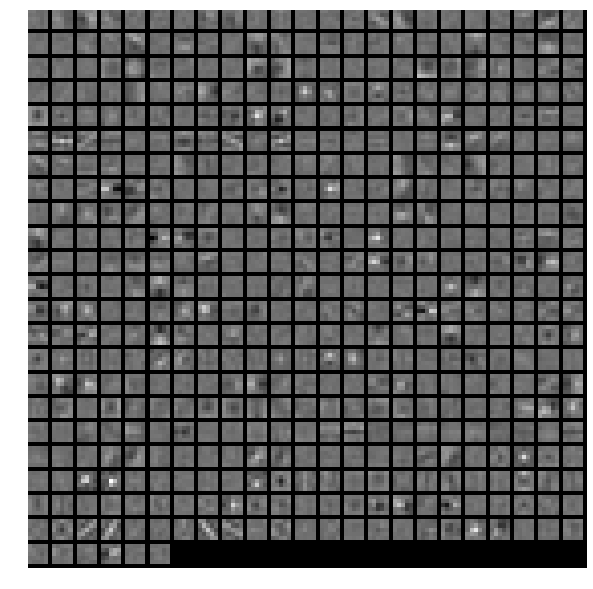

In [21]:
filters = net.params['inception_3a/5x5'][0].data
print(filters.shape)
vis_square(filters.reshape(32*16, 5, 5), padval=0, padsize=1)

インセプション層 I3a の出力の一部 (図11) は以下のようになっています。

(256, 28, 28)


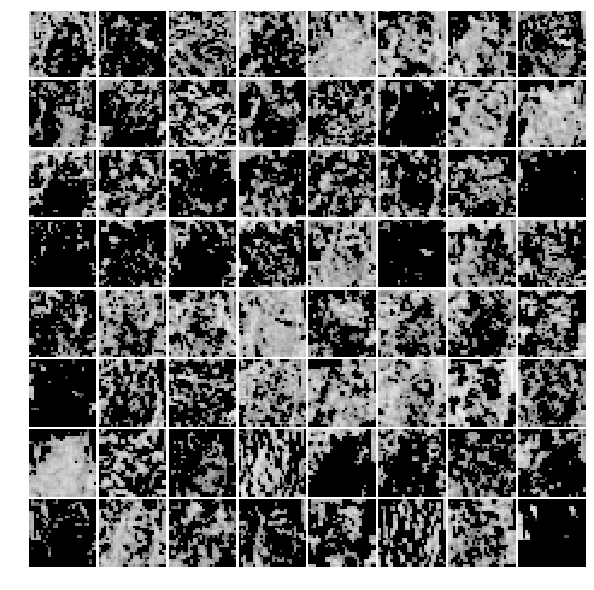

In [22]:
feat = net.blobs['inception_3a/output'].data[0]
print(feat.shape)
vis_square(feat[:64], padval=1, padsize=1, gamma=0.2)

### インセプション層 I3b の可視化

次は、インセプション層 I3b のフィルタと出力です (誌面には掲載していません)。

(96, 32, 5, 5)


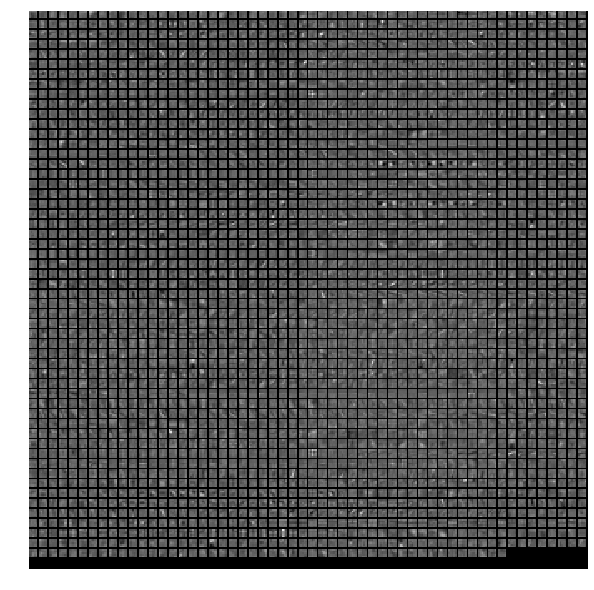

In [23]:
filters = net.params['inception_3b/5x5'][0].data
print(filters.shape)
vis_square(filters.reshape(96*32, 5, 5), padval=0, padsize=1)

(480, 28, 28)


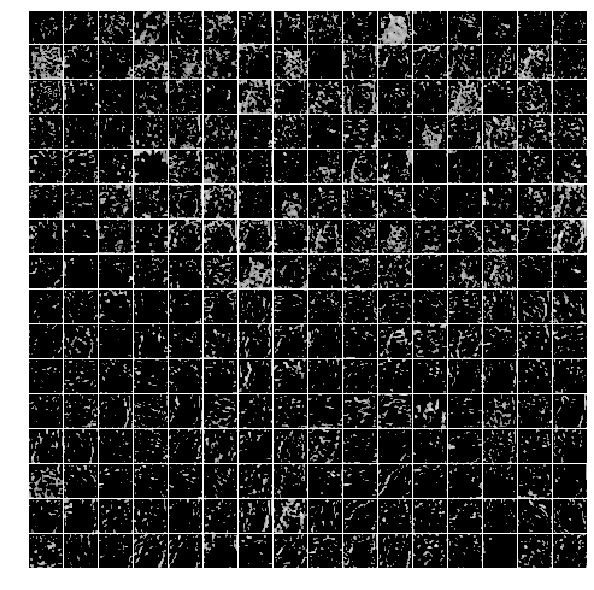

In [24]:
feat = net.blobs['inception_3b/output'].data[0]
print(feat.shape)
vis_square(feat[:256], padval=1, padsize=1, gamma=0.2)

### インセプション層 I4a の可視化

次は、インセプション層 I4a のフィルタと出力です (誌面には掲載していません)。

(48, 16, 5, 5)


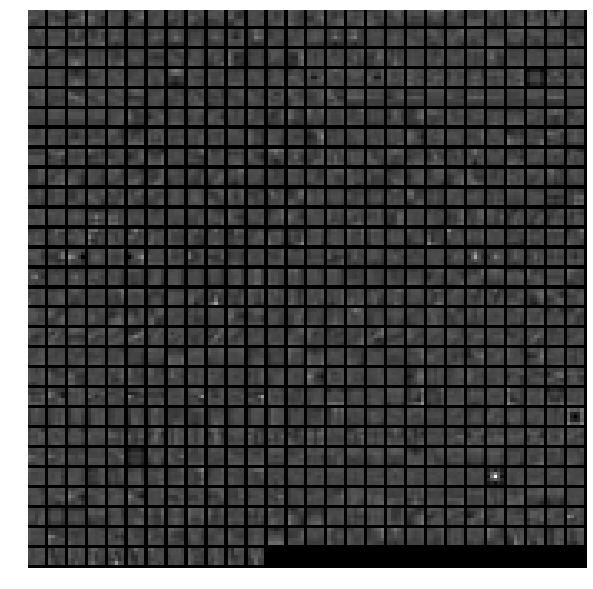

In [25]:
filters = net.params['inception_4a/5x5'][0].data
print(filters.shape)
vis_square(filters.reshape(48*16, 5, 5), padval=0, padsize=1)

(512, 14, 14)


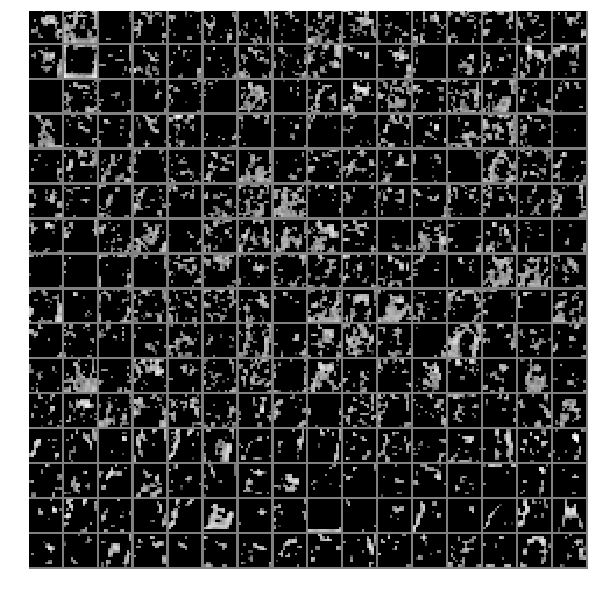

In [26]:
feat = net.blobs['inception_4a/output'].data[0]
print(feat.shape)
vis_square(feat[:256], padval=0.5, gamma=0.2)

### インセプション層 I4b の可視化

次は、インセプション層 I4b のフィルタと出力です (誌面には掲載していません)。

(64, 24, 5, 5)


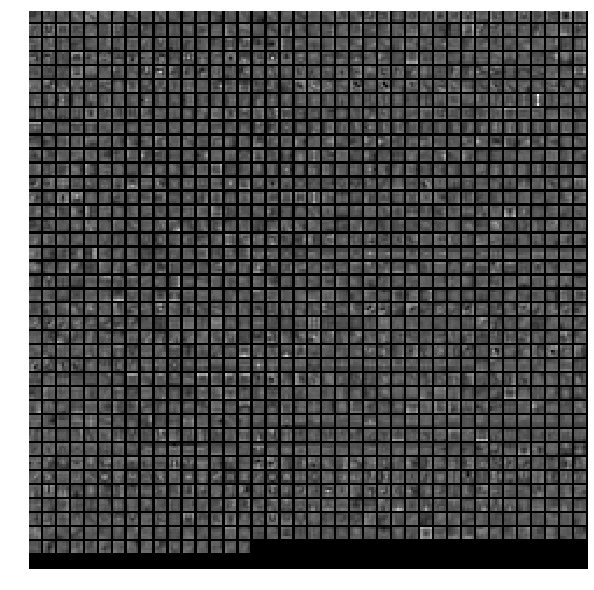

In [27]:
filters = net.params['inception_4b/5x5'][0].data
print(filters.shape)
vis_square(filters.reshape(64*24, 5, 5), padval=0, padsize=1)

(512, 14, 14)


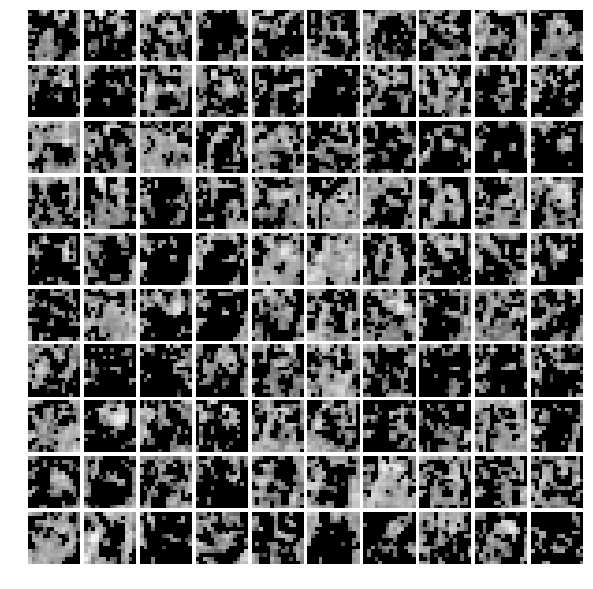

In [28]:
feat = net.blobs['inception_4b/output'].data[0]
print(feat.shape)
vis_square(feat[:100], padval=1, gamma=0.2)

### インセプション層 I4c の可視化

次は、インセプション層 I4c のフィルタと出力です (誌面には掲載していません)。

(64, 24, 5, 5)


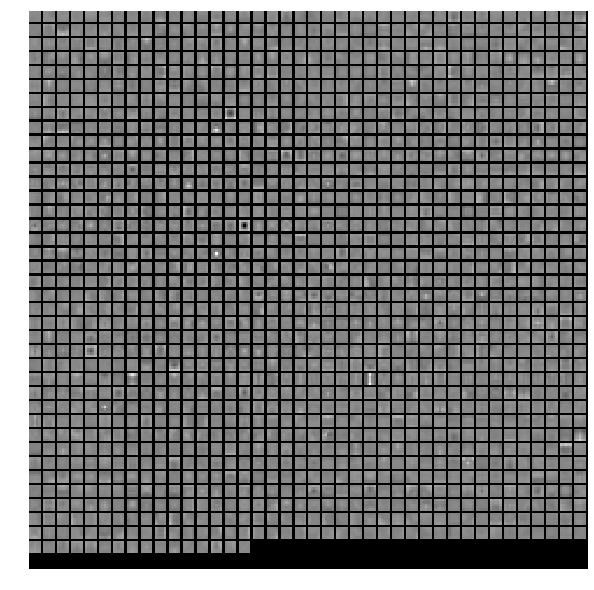

In [29]:
filters = net.params['inception_4c/5x5'][0].data
print(filters.shape)
vis_square(filters.reshape(64*24, 5, 5), padval=0, padsize=1)

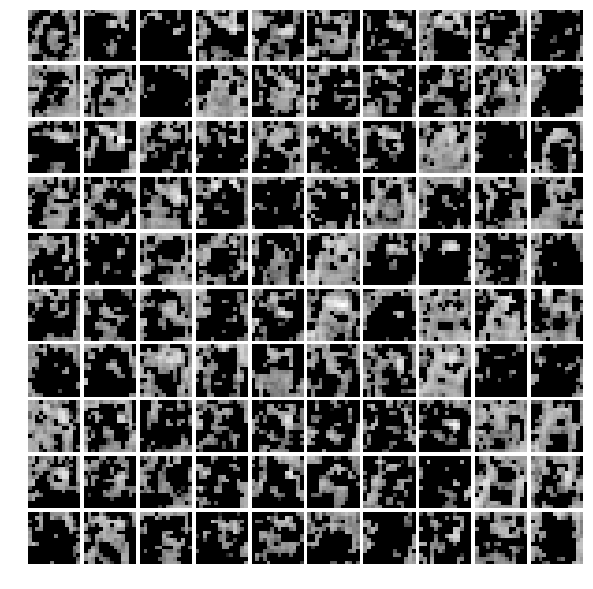

In [30]:
feat = net.blobs['inception_4c/output'].data[0, :100]
vis_square(feat, padval=1, gamma=0.2)

### インセプション層 I4d の可視化

次は、インセプション層 I4d のフィルタと出力です (誌面には掲載していません)。

(64, 32, 5, 5)


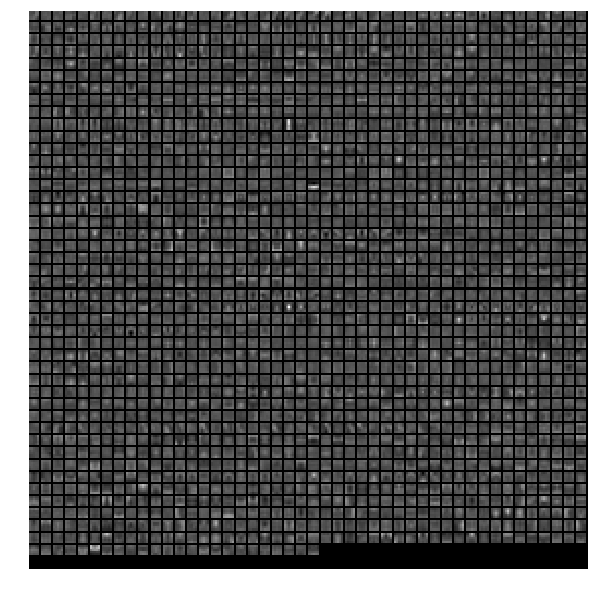

In [36]:
filters = net.params['inception_4d/5x5'][0].data
print(filters.shape)
vis_square(filters.reshape(64*32, 5, 5), padval=0, padsize=1)

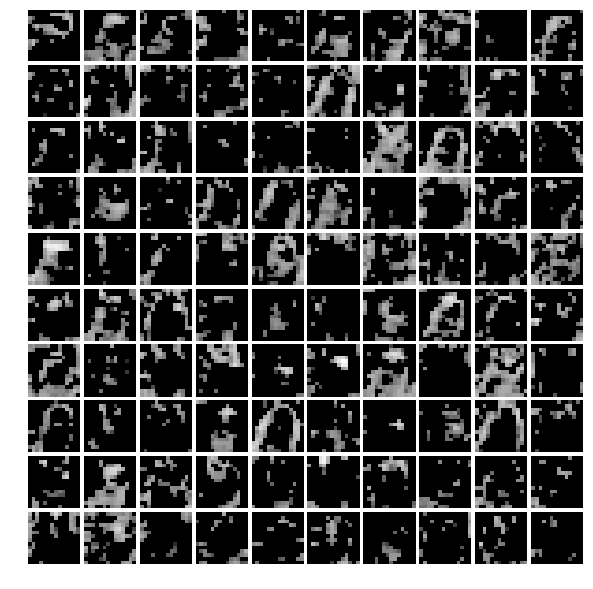

In [37]:
feat = net.blobs['inception_4d/output'].data[0, :100]
vis_square(feat, padval=1, gamma=0.2)

### インセプション層 I4e の可視化

次は、インセプション層 I4e のフィルタと出力です (誌面には掲載していません)。

(128, 32, 5, 5)


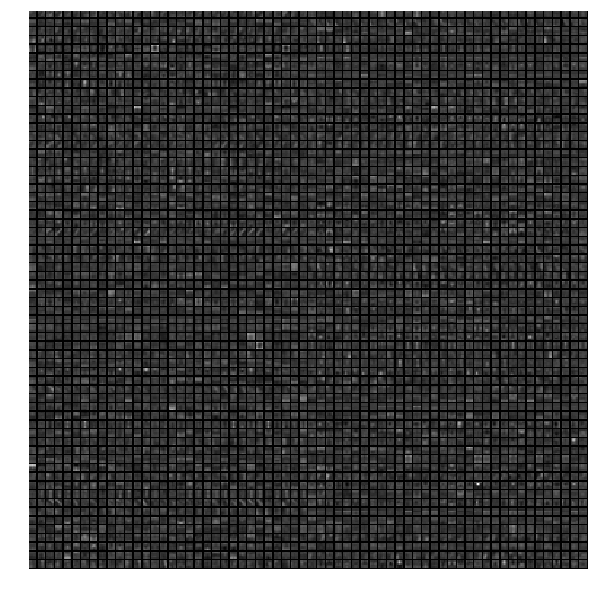

In [38]:
filters = net.params['inception_4e/5x5'][0].data
print(filters.shape)
vis_square(filters.reshape(128*32, 5, 5), padval=0, padsize=1)

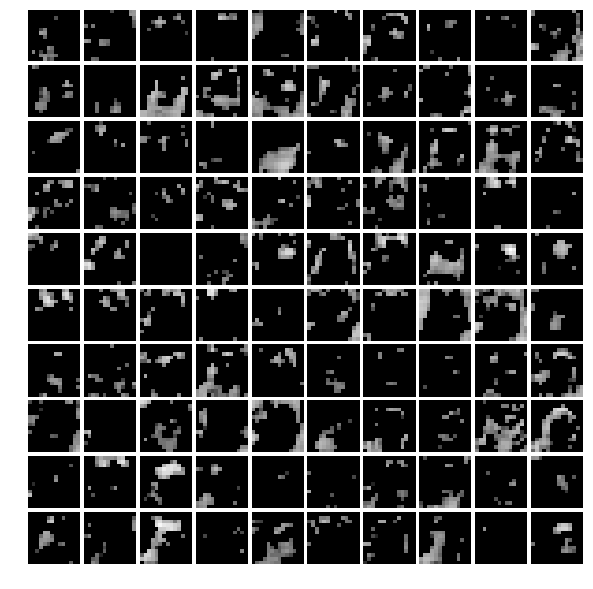

In [39]:
feat = net.blobs['inception_4e/output'].data[0, :100]
vis_square(feat, padval=1, gamma=0.2)

### インセプション層 I5a の可視化

インセプション層 I5a のフィルタと出力です (誌面には掲載していません)。

(128, 32, 5, 5)


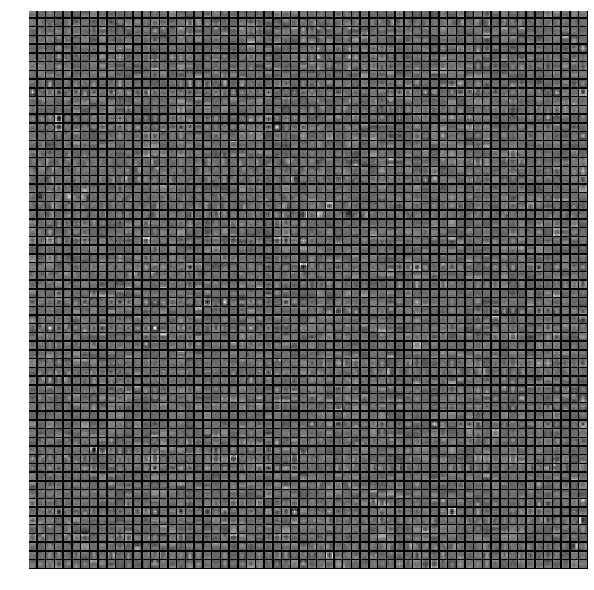

In [40]:
filters = net.params['inception_5a/5x5'][0].data
print(filters.shape)
vis_square(filters.reshape(128*32, 5, 5), padval=0, padsize=1)

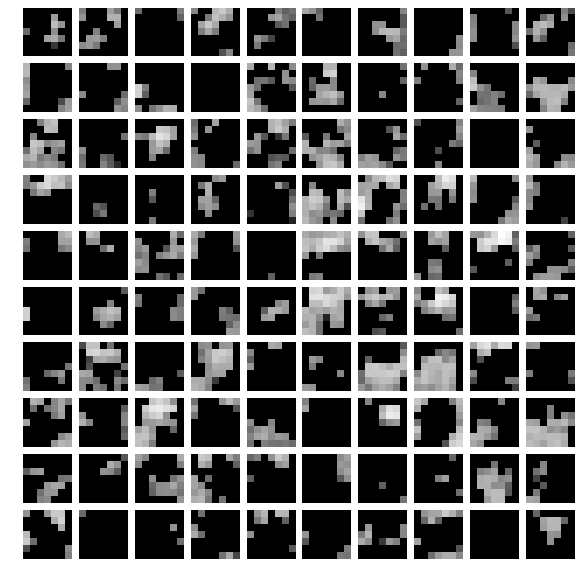

In [41]:
feat = net.blobs['inception_5a/output'].data[0, :100]
vis_square(feat, padval=1, gamma=0.2)

### インセプション層 I5b の可視化

インセプション層 I5b のフィルタと出力です (誌面には掲載していません)。

(128, 48, 5, 5)


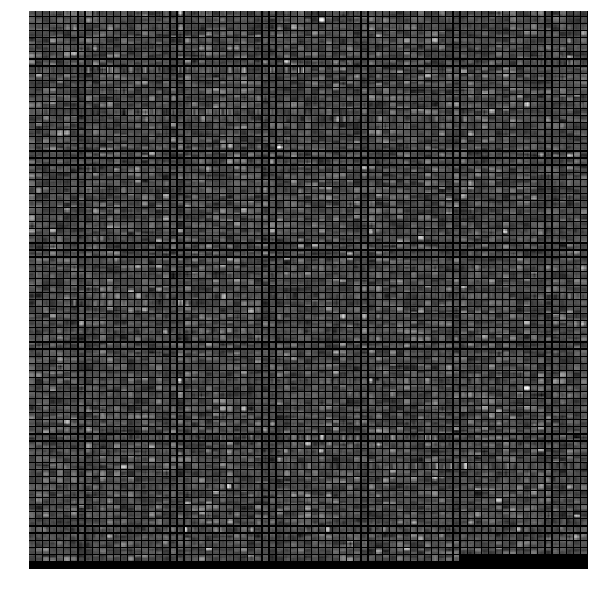

In [42]:
filters = net.params['inception_5b/5x5'][0].data
print(filters.shape)
vis_square(filters.reshape(128*48, 5, 5), padval=0, padsize=1)

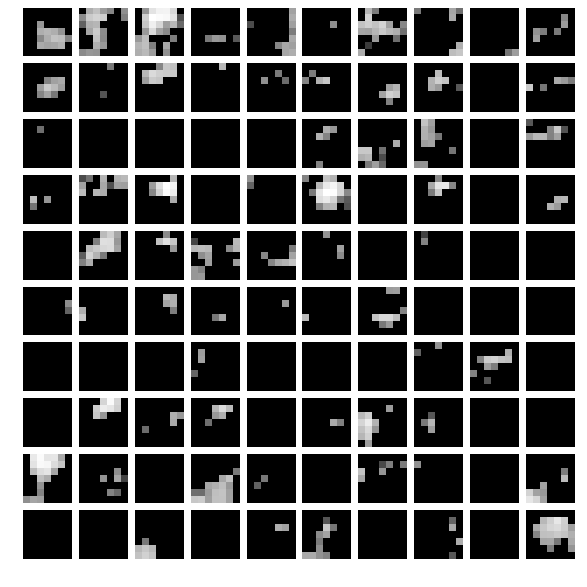

In [43]:
feat = net.blobs['inception_5b/output'].data[0, :100]
vis_square(feat, padval=1, gamma=0.2)

### 平均プーリング層 P5 の可視化

平均プーリング層 P5 の出力です (誌面には掲載していません)。

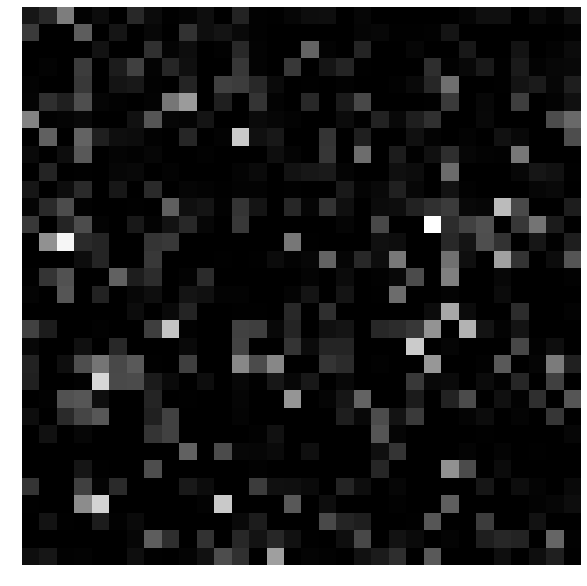

In [44]:
feat = net.blobs['pool5/7x7_s1'].data[0]
vis_square(feat, padval=0.5, padsize=0)

### 出力層の可視化

出力層のは確率ベクトルを出力します。これを可視化すると以下のようになります。

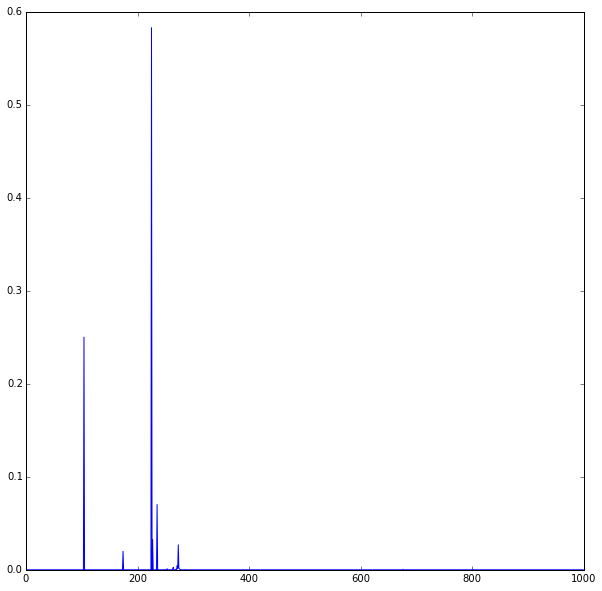

In [45]:
feat = net.blobs['prob'].data[0]
plt.plot(feat.flat)

確率が大きな順に9個のインデックスを表示すると以下のようになります。

In [46]:
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-10:-1]
for i, k in enumerate(top_k, start=1):
    print("{}: {}".format(i, k))

1: 225
2: 104
3: 235
4: 227
5: 273
6: 174
7: 271
8: 264
9: 274
